# 作业要求

用 Logistic Regression 和 SVM 分类 diabetes  数据库

比较两种算法的性能和特点



In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 数据预处理

In [3]:
data = pd.read_csv("diabetes.csv")
# print(data.describe())
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征缩放
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 模型选择

分别用Logistic回归和SVM模型处理该分类问题，并比较两种算法的分类性能。在比较性能时我们可以用K_fold交叉验证更可靠地估计性能，降低随机性的影响。我将先使用两种算法的基础形式，随后将在下一节“模型评估”加入K-fold。

In [4]:
# Logistic
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_prediction = logreg.predict(X_test)

# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_prediction = svm_model.predict(X_test)

Text(0.5, 1.0, 'Logistic Reg')

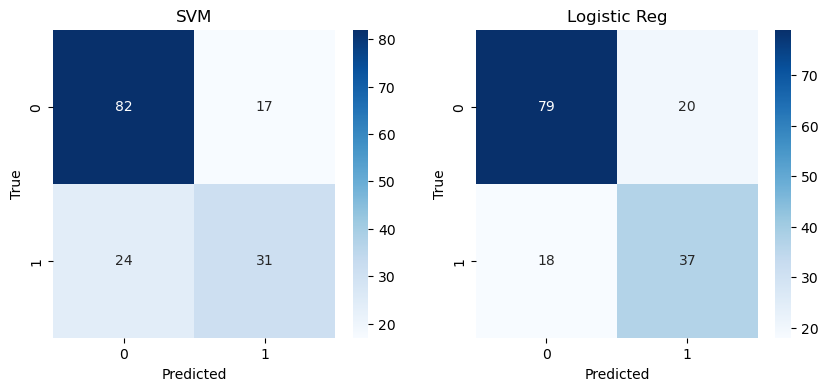

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_svm = confusion_matrix(y_test, svm_prediction)
cm_logreg = confusion_matrix(y_test, logreg_prediction)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(cm_svm, annot=True, cmap="Blues")
plt.title('SVM')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_logreg, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Reg')

画出两种方法对应的confusion matrix，发现逻辑回归的准确度略胜一筹

# 模型评估

上面是肉眼看，现在尝试用`sklearn.matrics`下的`accuracy_score`计算两种方法的准确度

In [21]:
logreg_accuracy = accuracy_score(y_test, logreg_prediction)
svm_accuracy = accuracy_score(y_test, svm_prediction)
print(f'Logistic regression accuracy: {logreg_accuracy:.3f}')
print(f'SVM accuracy: {svm_accuracy:.3f}')

Logistic regression accuracy: 0.753
SVM accuracy: 0.734


但SVM还没发挥出它的威力，接下来试试改变它的超参数（kernel，gamma和C），看看能不能提高准确度



## kernel

只要维度足够高，两组不同标签的数据是一定能被线性切割开的。kernel就是这样一个把数据集po到高维空间的函数。常用的有

- linear

$$
K(x,y)=x^Ty
$$

- polynomial

$$
K(x,y)=(\alpha x^Ty+c)^d
$$

- radial basis function kernel / Gaussian kernel


$$
K(x,y) = \exp (-\gamma \Vert x-y \Vert^2)
$$


- sigmoid kernel

$$
K(x,y) = \tanh (\alpha x^Ty+c)
$$

思路：先创建一个名为`svm_models`的字典，收藏不同kernel的模型。再用loop对每个模型进行fit，把训练好的模型放进字典里。（忽然发现字典挺好用的，不用考虑维度的问题，构思上比list更容易想。关键是加`.items()`就能转化成list，直接放进`pd.DataFrame`再加个index就能转化为数据框，方便数据处理）

In [78]:
svm_models = {}

kernel_type = ['linear','poly','rbf','sigmoid']
for kernel in kernel_type:
    model = SVC(kernel=kernel, C=1)
    model.fit(X_train,y_train)
    svm_models[kernel] = model

#print(svm_models.keys())
#print(svm_models.values())

同理，再创建一个名为`svm_scores`的字典，记录每种模型对应的准确度是多少

In [74]:
svm_scores = {}

for kernel, model in svm_models.items():
    prediction = model.predict(X_test)
    score = accuracy_score(y_test,prediction)
    svm_scores[kernel] = score

df_scores = pd.DataFrame(svm_scores, index=['Accuracy'])

另外我想再做个有趣的尝试，把训练集的分数也算一下（心中估计，四个分数都会非常高），看看过拟合的问题

In [75]:
train_scores = {}
for kernel,model in svm_models.items():
    prediction = model.predict(X_train)
    score = accuracy_score(y_train,prediction)
    train_scores[kernel] = score

df_train_scores = pd.DataFrame(train_scores, index=['Accuracy'])

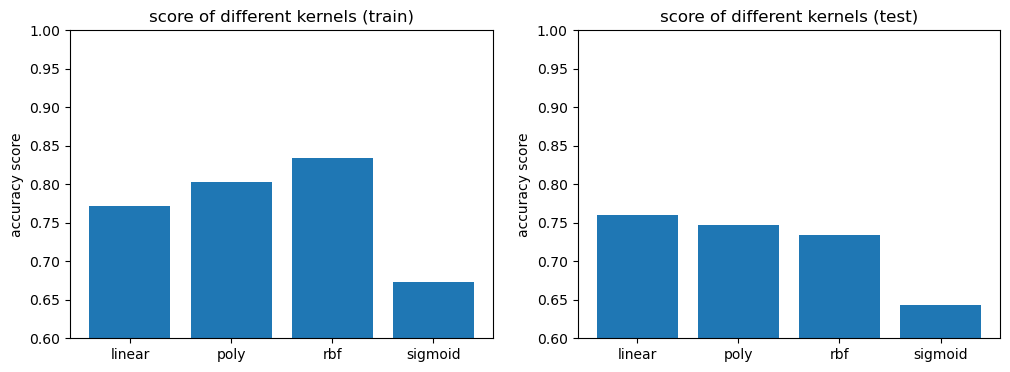

In [77]:
# 可视化
x1 = df_scores.columns
y1 = df_scores.iloc[0].to_list()

plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plt.bar(x1,y1)
plt.ylabel('accuracy score')
plt.title('score of different kernels (test)')
plt.ylim(0.6,1)

x2 = df_train_scores.columns
y2 = df_train_scores.iloc[0].to_list()
plt.subplot(1,2,1)
plt.bar(x2,y2)
plt.ylabel('accuracy score')
plt.title('score of different kernels (train)')
plt.ylim(0.6,1)

plt.show()

可以看到`rbf`明显过拟合了，`linear`差不多落在最优的那个点

## gamma

gamma是`rbf`特有的一个参数，小的gamma拟合曲线平滑，大的gamma会很扭曲。C是一个正则化参数，用来权衡最大化间隔和最小化错误。当C小时将更优先于最大化间隔，当C大时更优先于最小化错误（容易过拟合）。下面用`sklearn.model_selection`里的`GridSearchCV`来做交叉验证

In [88]:
param_grid = {
    'gamma': [0.1,1,10,100],
    'C': [0.1,1,10,100]
}
svm_model = SVC(kernel='rbf')
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train,y_train)

# 提取结果
results = grid_search.cv_results_
scores = results['mean_test_score']
scores = scores.reshape(len(param_grid['C']), len(param_grid['gamma']))
cv_scores = pd.DataFrame(scores, index=param_grid['C'], columns=param_grid['gamma'])

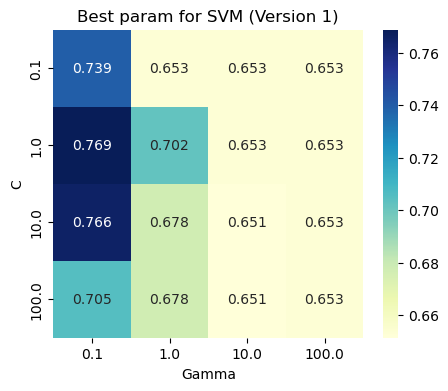

In [92]:
plt.figure(figsize=(5,4))
sns.heatmap(cv_scores, annot=True, fmt=".3f", cmap='YlGnBu')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Best param for SVM (Version 1)')
plt.show()

整体来看，gamma越大准确率越低，因为过拟合。而`C=1`处附近分数比较高，我们更新`param_grid`聚焦在这个范围，再做一次。这次gamma往更小的地方取，C以1为中心展开。

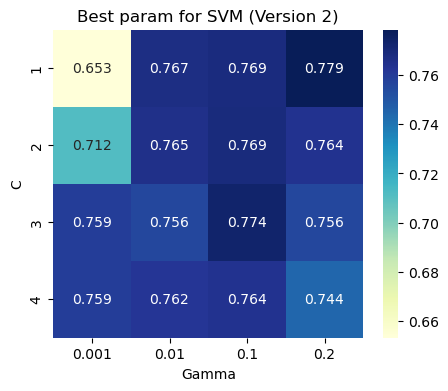

In [111]:
param_grid = {
    'gamma': [0.001,0.01,0.1,0.2],
    'C': [1,2,3,4]
}
svm_model = SVC(kernel='rbf')
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train,y_train)

# 提取结果
results = grid_search.cv_results_
scores = results['mean_test_score']
scores = scores.reshape(len(param_grid['C']), len(param_grid['gamma']))
cv_scores = pd.DataFrame(scores, index=param_grid['C'], columns=param_grid['gamma'])

plt.figure(figsize=(5,4))
sns.heatmap(cv_scores, annot=True, fmt=".3f", cmap='YlGnBu')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Best param for SVM (Version 2)')
plt.show()

In [97]:
best_param = grid_search.best_params_
print(best_param)

{'C': 3, 'gamma': 0.1}


由此可以确定比较好的参数是`C=3`，`gamma=0.1`。而且我们发现，添加这两个超参数后`rbf`对训练集拟合的分数从之前的0.85附近讲到0.77左右，可见过拟合有些缓解。下面对测试集操作

In [110]:
ultimate_model = SVC(kernel='rbf',gamma=0.1,C=3)
ultimate_model.fit(X_train,y_train)
ultimate_predict = ultimate_model.predict(X_test)
ultimate_score = accuracy_score(y_test,ultimate_predict)
print(f'准确率：{ultimate_score:.4f}')

准确率：0.7143


结果是0.7143，还不如引入gamma和C之前的。问题可能是gridsearch筛选出的是训练集下拟合最好的参数，但测试集中的最好才是最好。

In [115]:
gamma = np.arange(0.0, 0.21, 0.01).tolist()
C = np.arange(0.01,3.01,0.1).tolist() # C不能为0
best_score = 0
best_gamma = 0
best_C = 0

for g in gamma:
    for c in C:
        model = SVC(kernel='rbf',gamma=g,C=c)
        model.fit(X_train,y_train)
        predict = model.predict(X_test)
        score = accuracy_score(y_test,predict)
        if score > best_score:
            best_score, best_gamma, best_C = score, g, c

print(f'best score: {best_score:.4f}')
print(f'best gamma: {best_gamma:.2f}, best C: {best_C:.2f}')


best score: 0.8117
best gamma: 0.01, best C: 0.41


结论：最优分数0.8117，对应的gamma=0.01，C=0.41，提升很大

# 多分类问题

1. one vs all：一次分两类

2. Softmax regression

e.g. 三分类例子（用三维向量）

$$
\begin{bmatrix}
1\\
0\\
0
\end{bmatrix},
\begin{bmatrix}
0\\
1\\
0
\end{bmatrix},
\begin{bmatrix}
0\\
0\\
1
\end{bmatrix}
$$

$$
z=w^Tx \rightarrow 
\begin{bmatrix}
z_1\\
z_2\\
\vdots\\
z_k
\end{bmatrix}\xrightarrow{\displaystyle \frac{e^{z_i}}{\sum_i e^{z_i}}}
\begin{bmatrix}
p_1\\
p_2\\
\vdots\\
p_k
\end{bmatrix}
$$

$$
L_{CE}(y,p)=-\sum_{i=1}^k y_i\log p_i
$$

# 支持向量机 SVM

优化目标：最大化分类边界距离（margin）：结构风险最小化

函数表征：核函数

- 过去的linear reg，logistic reg函数表征都是polynomial

分类标签
- 过去的：$y_i\in \{0,1\}$
- 现在：$y_i\in \{1,-1\}$

Feature mapping可以增加一个轴把线性不可分变成可分

可以不知道feature mapping怎么搞，毕竟会维度爆炸，不知道$\phi^i$没事，知道$k(x^Tx)$就行

核函数本身就是超参数，要用交叉验证（CV）检验

`kernel,gamma,C`都是超参数

```python
clf.fit()
clf.predict()
```